# Initialization

In [21]:
import os
import json
import pandas as pd
import requests
import uuid
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import ast
from collections import Counter
from SPARQLWrapper import SPARQLWrapper, JSON
from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# set the maximum number of retries
MAX_RETRIES = 10

# Load environment variables
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialize OpenAI client
client = OpenAI(api_key=openai_api_key)

uuid = str(uuid.uuid4()).split("-")[-1]
uuid

# set the dataset name 
dataset_name = f"questions_{uuid}.csv"

Prepare the open-ended Questions

In [24]:
# Define the function to call GPT
def call_gpt(gpt_prompt, examples=""):
    attempts = 0
    while attempts < MAX_RETRIES:
        try:
            response = client.chat.completions.create(
                model="gpt-4o",
                response_format={"type": "json_object"},
                messages=[
                    {
                        "role": "system",
                        "content": "You are a helpful assistant designed to output JSON.",
                    },
                    (
                        {
                            "role": "user",
                            "content": gpt_prompt + "\nExamples: " + examples,
                        }
                        if examples
                        else {"role": "user", "content": gpt_prompt}
                    ),
                ],
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"Error calling GPT: {e}")
            continue

# Function to process a single API call
def process_call(i):
    # Define the prefix prompt
    prefix = """
        Generate 5 open-ended questions about different types: character description, event description, cause explanation, relationship explanation, trend prediction, outcome prediction, contrast analysis, historical comparison, evaluation and reflection, and application and practice. Some templates are provided below:

        character description: describe a [person]'s significant contributions during their career. Example: Please describe Albert Einstein’s contributions to the field of physics.

        event description: Provide a detailed description of the background and course of an [event]. Example: Please provide a detailed description of the background and course of the French Revolution.

        cause explanation: Why did [person] take [action] at [time]? Example: Why did Nixon choose to resign from the presidency in 1974?

        relationship explanation: Explain the relationship between [entity A] and [entity B] and its significance. Example: Explain the relationship between Alexander the Great and Aristotle and its significance.

        trend prediction: Based on the historical behavior of [entity], what do you think it might do in the future? Example: Based on Tesla’s historical behavior, in which fields do you think it might innovate in the future?

        outcome prediction: Based on the current situation, how do you predict [event] will develop? Example: Based on the current international situation, how do you predict climate change policies will develop?

        contrast analysis: Compare and contrast the similarities and differences between [entity A] and [entity B] in [aspect]. Example: Compare and contrast the leadership styles of Steve Jobs and Bill Gates.

        historical comparison: Compare the impact of [historical event A] and [historical event B]. Example: Compare the impact of World War I and World War II on the global order

        evaluation and reflection: How do you evaluate the impact of [person/event] on [field]? Please explain your viewpoint. Example: How do you evaluate Martin Luther King’s impact on the civil rights movement? Please explain your viewpoint.
        application and practice: How do you think [theory/method] can be applied to [practical issue]? Please provide specific suggestions. Example: How do you think machine learning technology can be applied to medical diagnostics? Please provide specific suggestions.

        Generate the questions, the type of the questions, the placeholders, the naturalness of your generated questions (choose from high, medium, and unnatural), the difficulty of the generated questions (choose from hard, medium and easy) and dbpedia_entities (link the placeholders to dbpedia entities) in JSON format.
    """

    example = """
        The following is an example of the output format:
        {'question': 'Compare and contrast the similarities and differences between the Apple iPhone and Samsung Galaxy in terms of user interface design.',
        'type': 'contrast analysis',
        'placeholders': {'entity A': 'Apple iPhone',
        'entity B': 'Samsung Galaxy',
        'aspect': 'user interface design'},
        'naturalness': 'high',
        'difficulty': 'medium',
        'dbpedia_entities': {'entity A': 'http://dbpedia.org/resource/IPhone',
        'entity B': 'http://dbpedia.org/resource/Samsung_Galaxy'}
        }
    """
    
    while True:
        try:
            raw_output = call_gpt(prefix, example)
            output = ast.literal_eval(raw_output)
            content = output.get("questions", "N/A")
            
            if content != "N/A":
                return content
        
        except (SyntaxError, ValueError):
            continue

if os.path.exists(dataset_name):
    df = pd.read_csv(dataset_name, index_col=0)
    df["dbpedia_entities"] = df["dbpedia_entities"].apply(lambda x: eval(x))
    df["placeholders"] = df["placeholders"].apply(lambda x: eval(x))
else:   
    results = []
    batch_size = 300
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = [executor.submit(process_call, i) for i in range(batch_size)]
        for future in tqdm(as_completed(futures), total=batch_size):
            result = future.result()
            if result:
                results.append(result)

    # Convert results to a DataFramex
    df = pd.DataFrame([item for sublist in results for item in sublist])
    df.to_csv(dataset_name)

100%|██████████| 300/300 [00:48<00:00,  6.14it/s]


post process the dataframe, remove the rows with same placeholders and dbepedia entities

In [26]:
def post_process(df: pd.DataFrame):
    unique_sample = set()
    rows_to_keep = []

    for i, row in df.iterrows():
        type = row["type"]
        question = row["question"]
        placeholders = row["placeholders"]
        dbpedia_entities = row["dbpedia_entities"]
        try:
            # frozenset is hashable
            placeholders = frozenset(row["placeholders"].items())
            dbpedia_entities = frozenset(row["dbpedia_entities"].items())
            if (row["type"], placeholders, dbpedia_entities) not in unique_sample:
                unique_sample.add((row["type"], placeholders, dbpedia_entities))
                rows_to_keep.append(i)

        except Exception as e:
            print(f"Error processing row {i}: {e}")
            print("placeholders: ", placeholders)
            print((row["type"], placeholders, dbpedia_entities))
            print("question: ", question)
            pass

    print(f"Number of unique samples: {len(unique_sample)}")
    df_filtered = df.iloc[rows_to_keep].reset_index(drop=True)

    return df_filtered


df_post_processed = post_process(df)
df_post_processed

Error processing row 1057: unhashable type: 'dict'
placeholders:  frozenset({('person', 'Leonardo da Vinci'), ('fields', 'art and science')})
('character description', frozenset({('person', 'Leonardo da Vinci'), ('fields', 'art and science')}), {'person': 'http://dbpedia.org/resource/Leonardo_da_Vinci', 'fields': {'art': 'http://dbpedia.org/resource/Art', 'science': 'http://dbpedia.org/resource/Science'}})
question:  Describe Leonardo da Vinci's significant contributions to the fields of art and science.
Number of unique samples: 880


,question,type,placeholders,naturalness,difficulty,dbpedia_entities
0,Please describe Ada Lovelace’s contributions t...,character description,{'person': 'Ada Lovelace'},high,medium,{'person': 'http://dbpedia.org/resource/Ada_Lo...
1,Provide a detailed description of the backgrou...,event description,{'event': 'Moon landing in 1969'},high,medium,{'event': 'http://dbpedia.org/resource/Apollo_...
2,Why did Mahatma Gandhi initiate the Salt March...,cause explanation,"{'person': 'Mahatma Gandhi', 'action': 'initia...",high,medium,{'person': 'http://dbpedia.org/resource/Mahatm...
3,Explain the relationship between the Roman Emp...,relationship explanation,"{'entity A': 'Roman Empire', 'entity B': 'Han ...",high,hard,{'entity A': 'http://dbpedia.org/resource/Roma...
4,"Based on Amazon's historical behavior, in whic...",trend prediction,{'entity': 'Amazon'},high,medium,{'entity': 'http://dbpedia.org/resource/Amazon...
...,...,...,...,...,...,...
875,How do you evaluate the impact of social media...,evaluation and reflection,"{'person/event': 'social media', 'field': 'pol...",high,medium,{'person/event': 'http://dbpedia.org/resource/...
876,Compare and contrast the similarities and diff...,contrast analysis,"{'entity A': 'New Deal', 'entity B': 'Great So...",high,hard,{'entity A': 'http://dbpedia.org/resource/New_...
877,Compare the impact of the American Revolutiona...,historical comparison,{'historical event A': 'American Revolutionary...,high,hard,{'historical event A': 'http://dbpedia.org/res...
878,How do you evaluate the impact of the Internet...,evaluation and reflection,"{'person/event': 'Internet', 'field': 'global ...",high,medium,{'person/event': 'http://dbpedia.org/resource/...


Check whether the dbpedia url is correct

In [27]:
def check_url(url):
    try:
        response = requests.get(url, timeout=5)  # Added a timeout for faster failure
        return response.status_code == 200
    except:
        return False


def verify_and_filter_entities(df):
    valid_rows = set()

    # use ThreadPoolExecutor for parallel calling of check_url()
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        # futures = {
        #     executor.submit(check_url, url): (index, key)
        #     for index, row in df.iterrows()
        #     for key, url in row['dbpedia_entities'].items()
        # }
        # comes from `concurrent.futures` module, and is used to represent a result that will be available in the future.
        futures = {}
        for index, row in df.iterrows():
            for key, url in row['dbpedia_entities'].items():
                future = executor.submit(check_url, url)
                futures[future] = (index, key)

        url_results = {}  # store the results of the futures
        # process the futures as they are completed
        for future in tqdm(as_completed(futures), total=len(futures)):
            url_results[futures[future]] = future.result()

    # iterate through the DataFrame rows to filter out invalid ones
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        valid = True
        for key, url in row['dbpedia_entities'].items():
            # if any URL is invalid, set valid to False and break
            if not url_results[(index, key)]:
                valid = False
                break
        if valid:
            valid_rows.add(index)

    filtered_df = df.loc[list(valid_rows)].reset_index(drop=True)
    return filtered_df


filtered_df = verify_and_filter_entities(df_post_processed)
filtered_df.to_csv(f"filtered_{dataset_name}.csv")
filtered_df

100%|██████████| 880/880 [00:00<00:00, 18189.82it/s]


,question,type,placeholders,naturalness,difficulty,dbpedia_entities
0,Please describe Ada Lovelace’s contributions t...,character description,{'person': 'Ada Lovelace'},high,medium,{'person': 'http://dbpedia.org/resource/Ada_Lo...
1,Provide a detailed description of the backgrou...,event description,{'event': 'Moon landing in 1969'},high,medium,{'event': 'http://dbpedia.org/resource/Apollo_...
2,Explain the relationship between the Roman Emp...,relationship explanation,"{'entity A': 'Roman Empire', 'entity B': 'Han ...",high,hard,{'entity A': 'http://dbpedia.org/resource/Roma...
3,"Based on Amazon's historical behavior, in whic...",trend prediction,{'entity': 'Amazon'},high,medium,{'entity': 'http://dbpedia.org/resource/Amazon...
4,Please describe Marie Curie's contributions to...,character description,{'person': 'Marie Curie'},high,medium,{'person': 'http://dbpedia.org/resource/Marie_...
...,...,...,...,...,...,...
845,Compare and contrast the similarities and diff...,contrast analysis,"{'entity A': 'Impressionist art', 'entity B': ...",high,medium,{'entity A': 'http://dbpedia.org/resource/Impr...
846,Compare and contrast the similarities and diff...,contrast analysis,"{'entity A': 'New Deal', 'entity B': 'Great So...",high,hard,{'entity A': 'http://dbpedia.org/resource/New_...
847,Compare the impact of the American Revolutiona...,historical comparison,{'historical event A': 'American Revolutionary...,high,hard,{'historical event A': 'http://dbpedia.org/res...
848,How do you evaluate the impact of the Internet...,evaluation and reflection,"{'person/event': 'Internet', 'field': 'global ...",high,medium,{'person/event': 'http://dbpedia.org/resource/...


Calculate the statistics

In [66]:
%pip install --upgrade tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tiktoken
    Found existing installation: tiktoken 0.6.0
    Uninstalling tiktoken-0.6.0:
      Successfully uninstalled tiktoken-0.6.0
Note: you may need to restart the kernel to use updated packages.


In [70]:
import tiktoken

def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613"):
    """Return the number of tokens used by a list of messages."""
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")
    if model in {
        "gpt-3.5-turbo-0613",
        "gpt-3.5-turbo-16k-0613",
        "gpt-4-0314",
        "gpt-4-32k-0314",
        "gpt-4-0613",
        "gpt-4-32k-0613",
        }:
        tokens_per_message = 3
        tokens_per_name = 1
    elif model == "gpt-3.5-turbo-0301":
        tokens_per_message = 4  # every message follows <|start|>{role/name}\n{content}<|end|>\n
        tokens_per_name = -1  # if there's a name, the role is omitted
    elif "gpt-3.5-turbo" in model:
        print("Warning: gpt-3.5-turbo may update over time. Returning num tokens assuming gpt-3.5-turbo-0613.")
        return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613")
    elif "gpt-4" in model:
        print("Warning: gpt-4 may update over time. Returning num tokens assuming gpt-4-0613.")
        return num_tokens_from_messages(messages, model="gpt-4-0613")
    else:
        raise NotImplementedError(
            f"""num_tokens_from_messages() is not implemented for model {model}."""
        )
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
    return num_tokens

# calculate the token length of the questions, the number of questions, the number of unique dbpedia entities
number_of_questions = len(filtered_df)

# Count the number of unique DBpedia entities
unique_dbpedia_entities = set()
for placeholder in filtered_df["placeholders"]:
    unique_dbpedia_entities.update(placeholder.values())
    
print(unique_dbpedia_entities)

# Display results
print(f"Number of questions: {number_of_questions}")
print(f"Number of unique DBpedia entities: {len(unique_dbpedia_entities)}")

avg_token_question = 0
for question in filtered_df["question"]:
    num_token = num_tokens_from_messages([{"content": question}])
    avg_token_question += num_token

avg_token_question = avg_token_question / number_of_questions
print(f"Average token length of questions: {avg_token_question}")

{'', 'global adoption of electric vehicles', 'pursue research on radioactivity', 'global education advocacy', 'radioactivity', 'Brexit', 'British Empire in the 19th century', 'their causes and outcomes', 'IBM', 'lead the United Kingdom', 'development of artificial intelligence', 'significant contribution', 'Disney', '1974', 'Java', 'decide to become an astronaut', 'voting systems', 'innovations and market trends in electric vehicles', 'global market', 'invention of the printing press', 'French cuisine', 'League of Nations', 'World War II history', 'food security issues', "India's independence movement", 'traditional public schooling', 'a leadership role in the Civil Rights Movement', 'psychology', 'artificial intelligence developments', 'COVID-19 pandemic', 'invade the Persian Empire', 'Capitalism', 'Florence Nightingale', 'global trade', '49 BC', 'advancements in renewable energy', 'secure online voting systems', 'enhance workplace productivity', 'persist in her research on radioactiv

In [45]:
# Count the number of questions for each type
type_counts = filtered_df["type"].value_counts()
type_counts

type
cause explanation            140
outcome prediction           130
contrast analysis            114
relationship explanation     111
evaluation and reflection    107
application and practice      95
character description         55
trend prediction              35
historical comparison         32
event description             31
Name: count, dtype: int64

In [29]:
# Count the number of questions for each naturalness
type_naturalness_counts = filtered_df.groupby(['type', 'naturalness']).size().unstack()
type_naturalness_counts

naturalness,high,medium
type,,
application and practice,93.0,2.0
cause explanation,135.0,5.0
character description,55.0,NaN
contrast analysis,113.0,1.0
evaluation and reflection,107.0,NaN
event description,31.0,NaN
historical comparison,32.0,NaN
outcome prediction,117.0,13.0
relationship explanation,108.0,3.0


In [74]:
type_difficulty_counts = filtered_df.groupby(['type', 'difficulty']).size().unstack()
type_difficulty_counts

difficulty,easy,hard,medium
type,,,
application and practice,NaN,12.0,83.0
cause explanation,NaN,32.0,108.0
character description,2.0,NaN,53.0
contrast analysis,NaN,53.0,61.0
evaluation and reflection,3.0,5.0,99.0
event description,NaN,11.0,20.0
historical comparison,NaN,21.0,11.0
outcome prediction,NaN,52.0,78.0
relationship explanation,2.0,24.0,85.0


/tmp/ipykernel_676954/3842824428.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette='viridis')


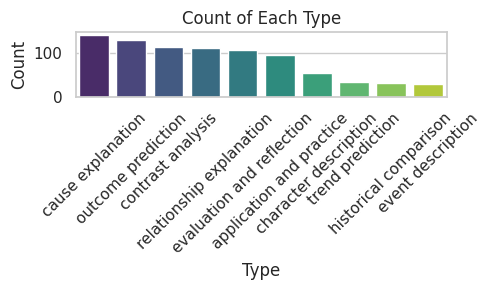

<Figure size 500x300 with 0 Axes>

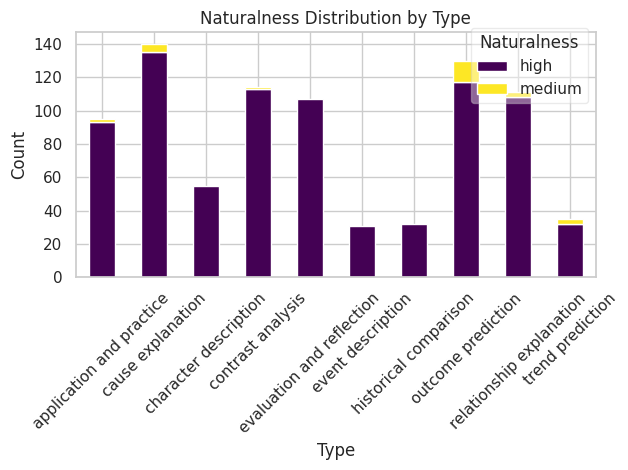

<Figure size 500x300 with 0 Axes>

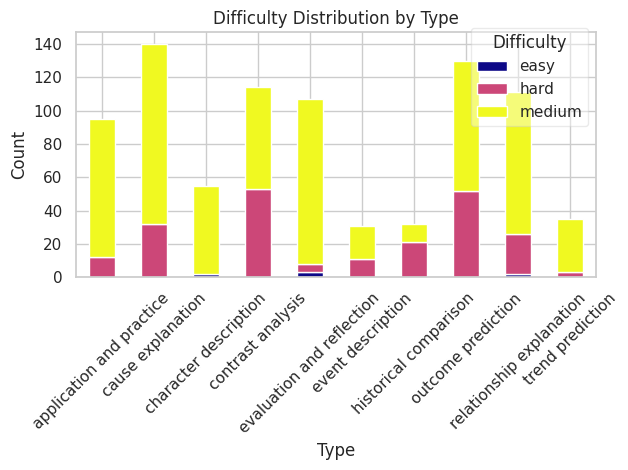

In [32]:
# set the style of the plots
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 3))
sns.barplot(x=type_counts.index, y=type_counts.values, palette='viridis')
plt.title('Count of Each Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/type_counts.png', dpi=300)
plt.show()

# plot the distribution of naturalness by type
plt.figure(figsize=(5, 3))
ax1 = type_naturalness_counts.plot(
    kind='bar', stacked=True, colormap='viridis', edgecolor='w'
)
plt.title('Naturalness Distribution by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(
    title='Naturalness', loc='upper right', bbox_to_anchor=(1, 1.05), framealpha=0.4
)
plt.tight_layout()
plt.savefig('figures/naturalness_distribution.png', dpi=300)
plt.show()

# plot the distribution of difficulty by type
plt.figure(figsize=(5, 3))
ax2 = type_difficulty_counts.plot(
    kind='bar', stacked=True, colormap='plasma', edgecolor='w'
)
plt.title('Difficulty Distribution by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(
    title='Difficulty', loc='upper right', bbox_to_anchor=(1, 1.05), framealpha=0.4
)
plt.tight_layout()
plt.savefig('figures/difficulty_distribution.png', dpi=300)
plt.show()

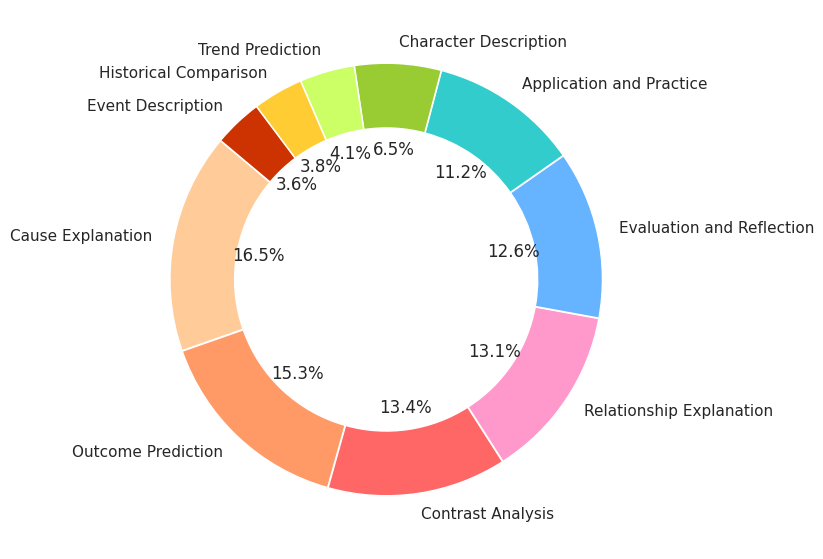

In [63]:
import matplotlib.pyplot as plt

# Data for the chart
categories = [
    'Cause Explanation', 'Outcome Prediction', 'Contrast Analysis', 
    'Relationship Explanation', 'Evaluation and Reflection', 
    'Application and Practice', 'Character Description', 
    'Trend Prediction', 'Historical Comparison', 'Event Description'
]
values = [140, 130, 114, 111, 107, 95, 55, 35, 32, 31]
# colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#c2f0c2','#ff6666','#c2d6d6','#ffb366']
colors = ['#ffcc99', '#ff9966', '#ff6666', '#ff99cc', '#66b3ff', '#33cccc', '#99cc33', '#ccff66', '#ffcc33', '#cc3300']


plt.figure(figsize=(7, 7))
plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'width': 0.3, 'edgecolor': 'w'}, explode=[0.003]*len(categories))
# plt.title('Distribution of Dataset - Donut Chart with Guide Lines')
plt.show()